In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from kinetic_function import (fit_function,
                              read_csv_file, 
                              read_csv_file_v2,
                              single_track_analysis,
                              autocorrelation,
                              fit_autocorrelation,
                              fit_autocorrelation_v2,
                              check_continuous_time,
                              calculate_MSD,
                              generate_track
                             )

In [2]:
prot_aa_size = {
    "32xsuntag": 796,  #768/32=24 , left 28
    "linker": 4,
    "twist": 490,
    "ilp4": 134,
    "snail": 390,
    "very_long_prot":2000, 
}

In [3]:
path_save = "/home/u2175049/Documents/Code/KineticAnalysis/notebook/figures/"
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/05-Modelling/06_RetentionTime/"

In [8]:
first_time = True
for rt in [0, 0.1, 1, 10, 50, 100]:
    for i in range(100):
        x_global, y_global, y_start_prot = generate_track(prot_length = prot_aa_size["snail"], 
                                                          suntag_length = prot_aa_size["32xsuntag"],
                                                          nb_suntag=32, 
                                                          fluo_one_suntag=4, 
                                                          translation_rate=24, 
                                                          binding_rate=0.05,
                                                          retention_time=rt,
                                                          suntag_pos=0,
                                                          step = 0.1,
                                                          length=6000)
        if first_time:
            datas = pd.DataFrame({"FRAME":x_global,
                                  "MEAN_INTENSITY_CH1":y_global,
                                  "TRACK_ID" : i,
                                  "RETENTION_TIME":rt,
                                 })
            first_time = False
        else:
            datas = pd.concat([datas, 
                               pd.DataFrame({"FRAME":x_global,
                                              "MEAN_INTENSITY_CH1":y_global,
                                              "TRACK_ID" : i,
                                             "RETENTION_TIME":rt,
                                 })], ignore_index=True)


datas.to_csv(os.path.join(path, "datas_retention_time_v2.csv"))

In [4]:
datas = pd.read_csv(os.path.join(path, "datas_retention_time_v2.csv"), index_col="Unnamed: 0")

In [6]:
path

'/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/05-Modelling/06_RetentionTime/'

In [5]:
first_time = True
dt = 3
t = dt/0.1
for rt in [0, 0.1, 1, 10, 50, 100]:
    prot_length = prot_aa_size["32xsuntag"]+prot_aa_size["snail"]
    for i in range(100):
        datas2 =datas[(datas["TRACK_ID"]==i) & (datas["RETENTION_TIME"]==rt)][::int(t)]
        (x, 
        y, 
        x_auto, 
        y_auto, 
        elongation_r, 
        translation_init_r,
        perr) = single_track_analysis(datas2,
                                     i, 
                                     delta_t = dt,
                                     protein_size=prot_length,
                                     normalise_intensity=1,
                                     normalize_auto=True,
                                     mm=None,
                                     lowpass_=False,
                                     cutoff=100,
                                     rtol=1e-1,
                                     method="linear",
                                     force_analysis=True,
                                     first_dot=True,
                                     simulation=True)
        if first_time:
            results = pd.DataFrame({"elongation_r":elongation_r, 
                                    "init_translation_r":translation_init_r, 
                                    "dt":dt,
                                   "id":i,
                                   "retention_time":rt},
                                  index=[0])
            first_time = False
        
        else:
            results = pd.concat([results, 
                            pd.DataFrame({"elongation_r":elongation_r, 
                                          "init_translation_r":translation_init_r, 
                                          "dt":dt, 
                                          "id":i,
                                         "retention_time":rt}, index=[0])
                            ], ignore_index=True)
# results.to_csv(os.path.join(path, "results_retention_time.csv"))

linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear method
linear

KeyboardInterrupt: 

In [11]:
results.groupby(by='retention_time')[['elongation_r','init_translation_r']].mean()

,elongation_r,init_translation_r
retention_time,,
0.0,20.954258,0.038503
0.1,21.489401,0.039234
1.0,20.124723,0.038592
10.0,17.723043,0.039515
50.0,10.705014,0.043386
100.0,7.073472,0.045492


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


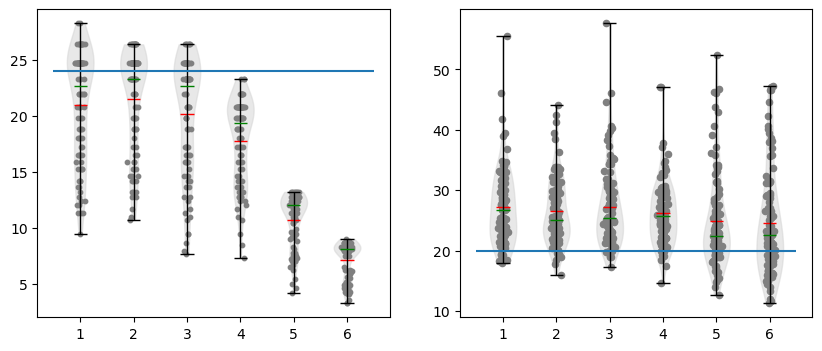

In [14]:
fig, ax = plt.subplots(1,2)
results['init_translation_r'] = 1/results['init_translation_r']
# results.boxplot(['elongation_r'] , 
#                by='retention_time', 
#                grid=False, 
#                ax = ax[0],
#                rot=90, 
#                 boxprops=dict(linestyle='-', linewidth=1.5, color="black"),
#                medianprops=dict(linestyle='-', linewidth=1.5, color="red"),
#               )

violin = ax[0].violinplot(dataset = [results[results.retention_time == 0.]["elongation_r"].values,
                                     results[results.retention_time == 0.1]["elongation_r"].values,
                                     results[results.retention_time == 1.]["elongation_r"].values,
                                     results[results.retention_time == 10.]["elongation_r"].values,
                                     results[results.retention_time == 50.]["elongation_r"].values,
                                     results[results.retention_time == 100.]["elongation_r"].values,
                          ],showmeans=True,
      showmedians=True)

for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)

colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1
    
# results.boxplot(['init_translation_r'] , 
#                by='retention_time', 
#                grid=False, 
#                ax = ax[1],
#                rot=90,
#                boxprops=dict(linestyle='-', linewidth=1.5, color="black"),
#                medianprops=dict(linestyle='-', linewidth=1.5, color="red"),
#                )

violin = ax[1].violinplot(dataset = [results[results.retention_time == 0.]["init_translation_r"].values,
                                     results[results.retention_time == 0.1]["init_translation_r"].values,
                                     results[results.retention_time == 1.]["init_translation_r"].values,
                                     results[results.retention_time == 10.]["init_translation_r"].values,
                                     results[results.retention_time == 50.]["init_translation_r"].values,
                                     results[results.retention_time == 100.]["init_translation_r"].values,
                                    ], showmeans=True,
      showmedians=True)


for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)

colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1
    
group = 'retention_time'
column = 'elongation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[0].scatter(x, val, c='grey', alpha=1, s=10)
    
group = 'retention_time'
column = 'init_translation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[1].scatter(x, val, c='grey', alpha=1, s=20)
    
# ax[1].set_ylim(0,250)
ax[0].hlines(24, 0.5, 6.5)
ax[1].hlines(1/0.05, 0.5, 6.5)
fig.set_size_inches((10,4))
fig.savefig(os.path.join(path_save, "results_retention_time_boxplot_original.eps"), dpi=300)

In [15]:
groupby_datas = pd.DataFrame(datas.groupby(["TRACK_ID", "RETENTION_TIME"]).mean()["MEAN_INTENSITY_CH1"])
groupby_datas["RETENTION_TIME"] = groupby_datas.index.get_level_values("RETENTION_TIME")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


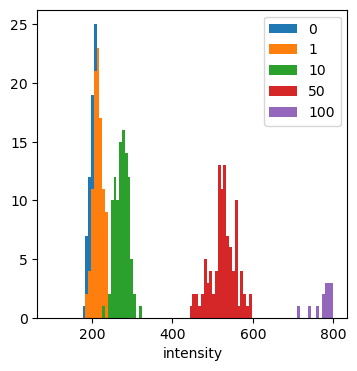

In [16]:
fig, ax = plt.subplots()
_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("RETENTION_TIME").isin([0])]["MEAN_INTENSITY_CH1"].to_numpy(), 
          bins=100, 
          range=[100,800],
         label="0")
_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("RETENTION_TIME").isin([1.0])]["MEAN_INTENSITY_CH1"].to_numpy(),
          bins=100, 
          range=[100,800],
         label="1")

_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("RETENTION_TIME").isin([10.0])]["MEAN_INTENSITY_CH1"].to_numpy(),
          bins=100, 
          range=[100,800],
         label="10")
_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("RETENTION_TIME").isin([50.0])]["MEAN_INTENSITY_CH1"].to_numpy(),
          bins=100, 
          range=[100,800],
         label="50")
_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("RETENTION_TIME").isin([100.0])]["MEAN_INTENSITY_CH1"].to_numpy(),
          bins=100, 
          range=[100,800],
         label="100")
ax.legend()
ax.set_xlabel("intensity")

fig.set_size_inches((4,4))
fig.savefig(os.path.join(path_save, "results_retention_time_hist.eps"), dpi=300)